In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import keras 

df = pd.read_pickle('dataset/train_dataset.pkl')


pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None) #50 for truncated view, -1 for full view

In [3]:

def get_train_test_dataset():
    split_date = '2015-12-28 10:29:13'
    data_train = df.loc[df['Timestamp'] <= split_date].copy()
    data_test = df.loc[df['Timestamp'] > split_date].copy()

    return data_train, data_test

In [4]:
training, test = get_train_test_dataset()
test = test.reset_index(drop=True)

cols_numeric = list(df.columns)

cols_numeric.remove('index')
cols_numeric.remove('attack')


#Transform to numeric data to be able to do the SC
# training['Timestamp'] = pd.to_numeric(training['Timestamp'])
training['Normal/Attack'].replace(['Normal', 'Attack'], [0, 1], inplace=True)

# test['Timestamp'] = pd.to_numeric(test['Timestamp'])
test['Normal/Attack'].replace(['Normal', 'Attack'], [0, 1], inplace=True)

# We only fit on the trainset to avoid data leakage from the testset
data_num = training[cols_numeric]
train_set = (data_num-data_num.min())/(data_num.max()-data_num.min())

test_num = test[cols_numeric]
test_set = (test_num-test_num.min())/(test_num.max()-test_num.min())


# size of sequence
TIME_STEPS = 10
number_of_row = 200000
date_test = test.loc[0:number_of_row-TIME_STEPS, 'Timestamp']

# scaler = StandardScaler().fit(data)
# train_set = scaler.transform(data)


# scaler = StandardScaler().fit(test)
# test_set = scaler.transform(test)

In [5]:
cols_numeric = list(df.columns)
cols_numeric.remove('Timestamp')
cols_numeric.remove('index')
cols_numeric.remove('attack')

cols_set_to_remove = []
cols_test_to_remove = []
for col in cols_numeric:
    
    var = np.var(test_set[col])
    if var == 0 or np.isnan(var):
        cols_test_to_remove += [col]
        print(col)
        test_set[col] = test_set[col].fillna(0)
        
    var = np.var(train_set[col])
    if var == 0 or np.isnan(var):
        cols_set_to_remove += [col]
        print(col)
        train_set[col] = train_set[col].fillna(0)

P102
P201
P204
P206
P301
P402
P403
UV401
P501
Normal/Attack


In [6]:
cols_remove = cols_set_to_remove + cols_test_to_remove

In [7]:

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])

    return np.asarray(Xs).astype(np.float32), np.asarray(ys).astype(np.float32)

In [21]:

cols = ['FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201',
       'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204',
       'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302',
       'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401',
       'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502',
       'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501',
       'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603']

to_remove = ['P202','P401','P404','P502','P601','P603'] + cols_remove

cols = [i for i in cols if i not in to_remove]
# features = ['LIT101']
# cols.remove(features[0])
features = cols

# size of sequence
TIME_STEPS = 10

# reshape to [samples, time_steps, n_features]
# train = train_set.loc[0:number_of_row-1, cols+features]
# test = test_set.loc[0:number_of_row-1, cols+features]
train_len = len(train_set)
# test_len = number_of_row

train = train_set.loc[0:train_len-1, cols]
# test = test_set.loc[0:test_len-1, cols+features]

X_train, y_train = create_dataset(train[cols], train[features], TIME_STEPS)

# test = test_set.loc[0:test_len-1, cols+features]

# X_test, y_test = create_dataset(test[cols], test[features], TIME_STEPS)


In [10]:
print(X_train.shape, y_train.shape)

(484144, 10, 72) (484144, 72)


# Create Model

In [11]:
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed


In [25]:
model = Sequential()
model.add(LSTM(units=64, activation='softmax', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(n=X_train.shape[1]))
model.add(LSTM(units=64, activation='relu', return_sequences=False))
model.add(Dropout(rate=0.2))
# model.add(Dense(y_train.shape[1]))
model.add(Dense(units=y_train.shape[1]))

model.compile(loss='mae', optimizer='adam')

In [ ]:
# model = Sequential()
# model.add(LSTM(64, activation='softmax', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# model.add(LSTM(32, activation='relu', return_sequences=False))
# model.add(Dropout(0.5))

# # model.add(Dense(y_train.shape[1]))
# model.add(TimeDistributed(Dense(units=y_train.shape[1])))

# model.compile(optimizer='adam', loss="mean_squared_error")#run_eagerly=True

In [26]:

from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
batch_size = 16
epochs = 4

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    # validation_data=(X_test, y_test),
                    workers=10,
                    use_multiprocessing=True
                   )


Epoch 1/4
30259/30259 [==============================] - 228s 7ms/step - loss: 0.0615
Epoch 2/4
30259/30259 [==============================] - 232s 8ms/step - loss: 0.0426
Epoch 3/4
30259/30259 [==============================] - 209s 7ms/step - loss: 0.0406
Epoch 4/4
30259/30259 [==============================] - 241s 8ms/step - loss: 0.0399


In [27]:
test_len = len(test_set)

test = test_set.loc[0:test_len-1, cols]

X_test, y_test = create_dataset(test[cols], test[features], TIME_STEPS)


In [28]:
X_test_pred = model.predict(X_test)


14005/14005 [==============================] - 53s 4ms/step


In [16]:
X_test_pred.shape

(448155, 72)

In [326]:
y_test.shape


(19970, 36)

(-0.2, 1.2)

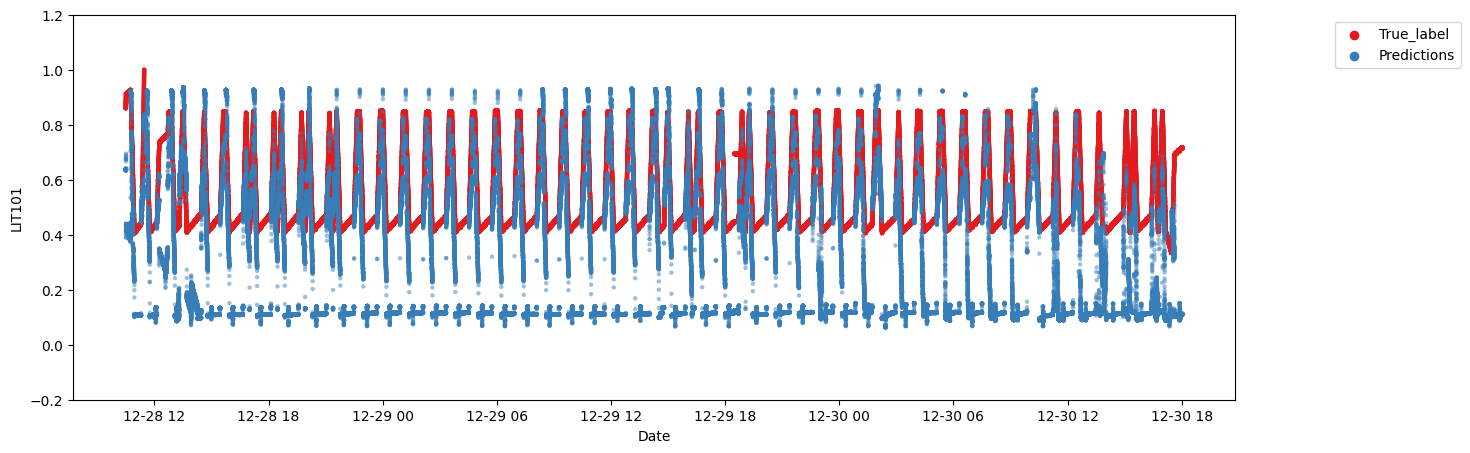

In [30]:
how_much_in_futur = 29

feature = 'LIT101'
# index = 0
index = list(cols).index(feature) # for multiple features

X = X_test_pred[:, index]
y = y_test[:, index]

arr = [float(X[i]) for i in range(len(X))]
predictions = pd.DataFrame({'Predictions': arr})
true_label = pd.DataFrame({'True_label': y.flatten()})

result = pd.concat([true_label, predictions, date_test], axis=1)

data_melt = pd.melt(result.reset_index(), id_vars=['Timestamp'], value_vars=['True_label', 'Predictions'])
g = sns.scatterplot(x='Timestamp', y='value', hue='variable', data=data_melt, palette='Set1', alpha=0.5, s=10, linewidth=0, legend='full')
g.set(xlabel='Date', ylabel=feature)
g.legend(loc='upper right', bbox_to_anchor=(1.2, 1), ncol=1)
g.figure.set_size_inches(15, 5)
g.set_ylim([-0.2, 1.2])


In [ ]:
how_much_in_futur = 29

arr = [float(X_test_pred[i][how_much_in_futur]) for i in range(len(X_test_pred))]
predictions = pd.DataFrame({'Predictions': arr})
true_label = pd.DataFrame({'True_label': y_test.flatten()})

result = pd.concat([true_label, predictions, date_test], axis=1)

data_melt = pd.melt(result.reset_index(), id_vars=['Timestamp'], value_vars=['True_label', 'Predictions'])
g = sns.scatterplot(x='Timestamp', y='value', hue='variable', data=data_melt, palette='Set1', alpha=0.5, s=10, linewidth=0, legend='full')
g.set(xlabel='Date', ylabel='PIT503')
g.legend(loc='upper right', bbox_to_anchor=(1.2, 1), ncol=1)
g.figure.set_size_inches(15, 5)
g.set_ylim([0, 1.2])


In [31]:
THRESHOLD = 0.75

test_score_df = pd.DataFrame(index=test_set[TIME_STEPS:test_len].index)

test_score_df['threshold'] = THRESHOLD

for feature in cols:
    index = list(cols).index(feature)

    test_mae_loss = np.abs(X_test_pred[:, index] - y_test[:, index])

    test_score_df[f'loss_{feature}'] = test_mae_loss
    test_score_df[f'anomaly_{feature}'] = test_score_df[f'loss_{feature}'] > test_score_df['threshold']
    test_score_df[feature] = test[TIME_STEPS:][feature]


/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_1594/1834657814.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_score_df[f'loss_{feature}'] = test_mae_loss
/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_1594/1834657814.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_score_df[f'anomaly_{feature}'] = test_score_df[f'loss_{feature}'] > test_score_df['threshold']
/var/folders/cc/whpcb33912lfp0b714xmf83m0000gn/T/ipykernel_1594/1834657814.py:14: PerformanceWarning: DataFrame is highly fragmen

In [32]:

cols_anomaly = [col for col in test_score_df.columns if 'anomaly' in col]
test_score_df['anomaly'] = test_score_df[cols_anomaly].sum(axis=1)

NameError: name 'time_x' is not defined

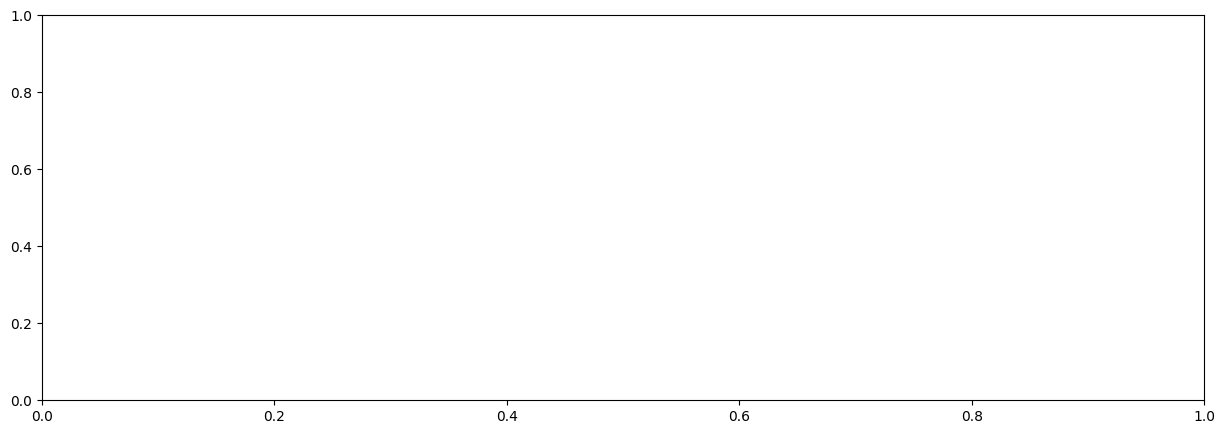

In [33]:
plt.subplots(figsize=(15, 5))

plt.plot(time_x, test_score_df['anomaly'], label='anomaly')
plt.plot(time_x, test['Normal/Attack'].iloc[0:number_of_row-TIME_STEPS]*8, label='attack')
plt.plot(time_x, [4 for i in range(len(test_score_df))], label='threshold')


In [41]:
training, test = get_train_test_dataset()
test = test.reset_index(drop=True)
test['Normal/Attack'] = test['Normal/Attack'].map({'Normal': 0, 'Attack': 1})

time_x = test['Timestamp'].iloc[0:test_len-TIME_STEPS]


In [40]:

test_score_df_remove = pd.DataFrame(index=test_set[TIME_STEPS:test_len].index)

for feature in cols_remove:
    value_train = training[feature].iloc[0:test_len].unique()[0]
    value_test = test[feature].iloc[0:test_len].to_frame()
    
    value_test['attack'] = value_test.apply(lambda x: True if x[feature] != value_train else False, axis=1)
    
    test_score_df_remove[f'attack_{feature}'] = value_test['attack']

In [42]:

test_score_df_remove['anomaly'] = test_score_df_remove.sum(axis=1)

In [43]:
test_score_df_remove['anomaly'].value_counts()

1    357376
2     57366
4     32331
3      1082
Name: anomaly, dtype: int64

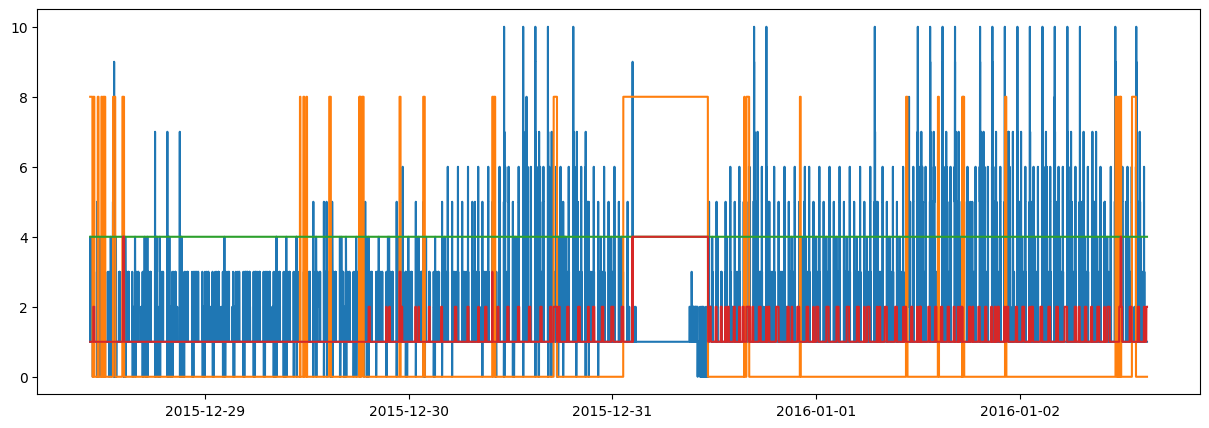

In [45]:
plt.subplots(figsize=(15, 5))

plt.plot(time_x, test_score_df['anomaly'], label='anomaly')
plt.plot(time_x, test['Normal/Attack'].iloc[0:test_len-TIME_STEPS]*8, label='attack')
plt.plot(time_x, [4 for i in range(len(test_score_df))], label='threshold')
plt.plot(time_x, test_score_df_remove['anomaly'], label='anomaly_remove')


In [ ]:

import matplotlib.pyplot as plt

plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

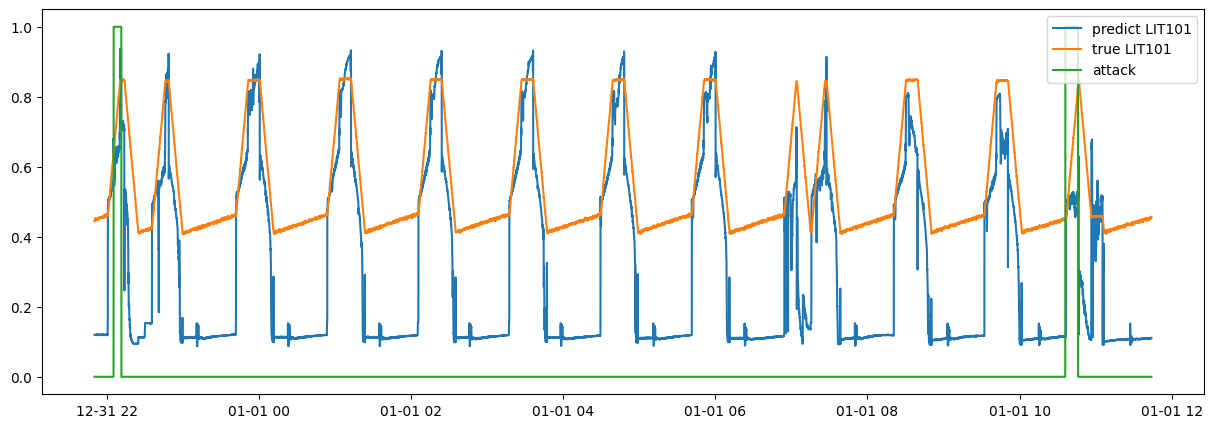

In [60]:

feature = 'LIT101'
index = list(cols).index(feature)

time_1 = 50000 * 6
time_2 = 50000 * 7

time_x = test['Timestamp'].iloc[time_1:time_2]

plt.subplots(figsize=(15, 5))
plt.plot(time_x, X_test_pred[time_1:time_2, index], label='predict '+feature)
plt.plot(time_x, y_test[time_1:time_2, index], label='true '+feature)
plt.plot(time_x, test['Normal/Attack'].iloc[time_1:time_2], label='attack')

plt.legend();